Example 06

Solution of the Poisson equation in 2D

$$
k_i \nabla^2 u = f
$$

with $k_i$ discontinuous due to materials with different properties, but with $u$ continuous.

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

plt.style.use(["seaborn-v0_8-darkgrid", "seaborn-v0_8-colorblind", "seaborn-v0_8-talk"])
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["legend.framealpha"] = 0.1

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

# Geometry

First, we define the geometry of the domain using the `calfem-python` library.

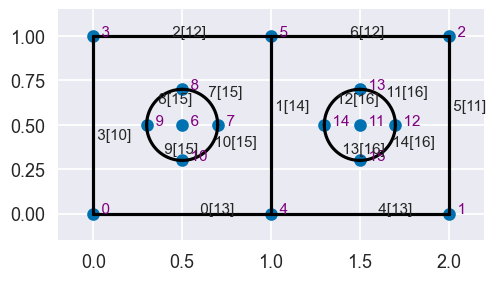

In [2]:
g = cfg.Geometry()

# points
#   corners
g.point([0,0])
g.point([2,0])
g.point([2,1])
g.point([0,1])

#   interface
g.point([1,0])
g.point([1,1])

#   left-circle
g.point([0.5,0.5])
g.point([0.7,0.5])
g.point([0.5,0.7])
g.point([0.3,0.5])
g.point([0.5,0.3])

#   right-circle
g.point([1.5,0.5])
g.point([1.7,0.5])
g.point([1.5,0.7])
g.point([1.3,0.5])
g.point([1.5,0.3])

# lines
left_marker = 10
right_marker = 11
top_marker = 12
bottom_marker = 13
interface_marker = 14
left_circ_mark = 15
right_circ_mark = 16

#   left-half
g.spline([0,4], marker=bottom_marker)
g.spline([4,5], marker=interface_marker)
g.spline([5,3], marker=top_marker)
g.spline([3,0], marker=left_marker)

#   right-half
g.spline([4,1], marker=bottom_marker)
g.spline([1,2], marker=right_marker)
g.spline([2,5], marker=top_marker)

#   left-circle
g.circle([7,6,8], marker=left_circ_mark)
g.circle([8,6,9], marker=left_circ_mark)
g.circle([9,6,10], marker=left_circ_mark)
g.circle([10,6,7], marker=left_circ_mark)

#   right-circle
g.circle([12,11,13], marker=right_circ_mark)
g.circle([13,11,14], marker=right_circ_mark)
g.circle([14,11,15], marker=right_circ_mark)
g.circle([15,11,12], marker=right_circ_mark)

# surfaces
left_half_mark = 0
right_half_mark = 1
left_circ_surf_mark = 2
#   left-half
g.surface(outer_loop=[0,1,2,3], holes=[[7,8,9,10]], marker=left_half_mark)
#   left-circle
g.surface([7,8,9,10], marker=left_circ_surf_mark)
#   right-half
g.surface([4,5,6,1], [[11,12,13,14]], marker=right_half_mark)

# geometry plot
plt.figure(figsize=(8,3))
cfv.draw_geometry(g,draw_axis=True)

# Mesh

From the geometry, `calfem` also generates the mesh.

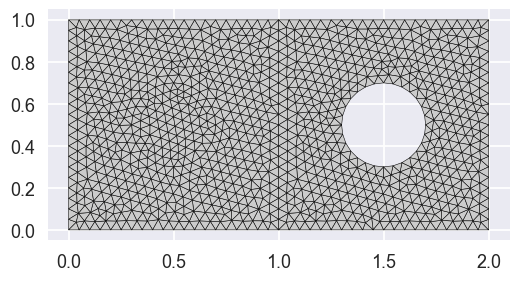

In [3]:
mesh = cfm.GmshMesh(g,el_size_factor=0.05)

coords, edof, dofs, bdofs, elementmarkers = mesh.create()
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

plt.figure(figsize=(8,3))
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True
)

In [4]:
coords.shape

(1073, 2)

# Identify the indices of the different boundaries and interfaces

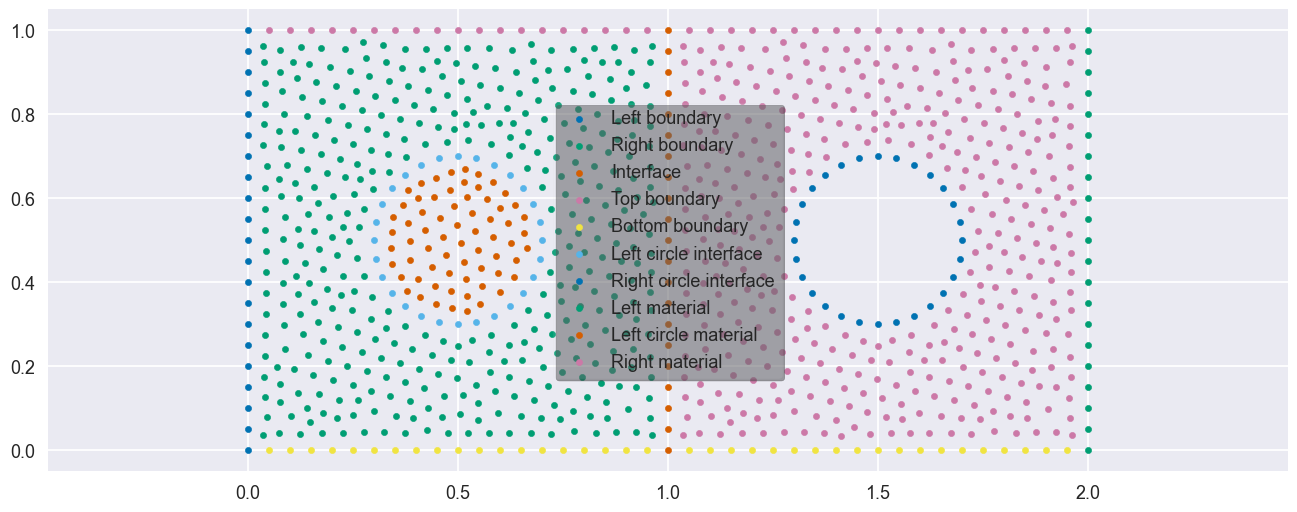

In [9]:
# boundaries
left_nodes = np.asarray(bdofs[left_marker]) - 1

right_nodes = np.asarray(bdofs[right_marker]) - 1

interface_nodes = np.asarray(bdofs[interface_marker]) - 1

top_nodes = np.asarray(bdofs[top_marker]) - 1
top_nodes = np.setdiff1d(top_nodes, [2,5,3])

bottom_nodes = np.asarray(bdofs[bottom_marker]) - 1
bottom_nodes = np.setdiff1d(bottom_nodes, [0,4,1])

left_circ_nodes = np.asarray(bdofs[left_circ_mark]) - 1

right_circ_nodes = np.asarray(bdofs[right_circ_mark]) - 1

boundary_nodes = np.hstack((
    left_nodes,
    right_nodes,
    interface_nodes,
    top_nodes,
    bottom_nodes,
    left_circ_nodes,
    right_circ_nodes
))

# interior nodes
elementmarkers = np.asarray(elementmarkers)

left_half_nodes = faces[elementmarkers == left_half_mark]
left_half_nodes = left_half_nodes.flatten()
left_half_nodes = np.setdiff1d(left_half_nodes, boundary_nodes)

left_circ_mat_nodes = faces[elementmarkers == left_circ_surf_mark]
left_circ_mat_nodes = left_circ_mat_nodes.flatten()
left_circ_mat_nodes = np.setdiff1d(left_circ_mat_nodes, boundary_nodes)

right_half_nodes = faces[elementmarkers == right_half_mark]
right_half_nodes = right_half_nodes.flatten()
right_half_nodes = np.setdiff1d(right_half_nodes, boundary_nodes)

# plotting
plt.figure(figsize=(16,6))
boundaries_to_plot = (
    left_nodes,
    right_nodes,
    interface_nodes,
    top_nodes,
    bottom_nodes,
    left_circ_nodes,
    right_circ_nodes,
    left_half_nodes,
    left_circ_mat_nodes,
    right_half_nodes
)
labels_to_plot = (
    "Left boundary",
    "Right boundary",
    "Interface",
    "Top boundary",
    "Bottom boundary",
    "Left circle interface",
    "Right circle interface",
    "Left material",
    "Left circle material",
    "Right material"
)
for b,label in zip(boundaries_to_plot, labels_to_plot):
    plt.scatter(coords[b,0], coords[b,1], label=label, s=20)

plt.axis("equal")
plt.legend(loc="center")

# Testing normal vectors

Normal vectors are computed for Neumann boundaries and interfaces using the `normal_vectors` function from the `GFDMI` module, which handles this computation automatically. Here’s an example of how to use it.

(np.float64(1.28),
 np.float64(1.72),
 np.float64(0.27999999999999997),
 np.float64(0.72))

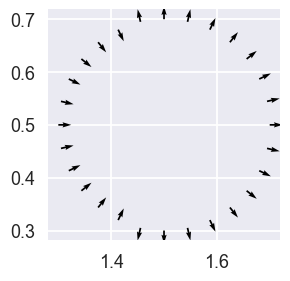

In [20]:
from GFDMI import normal_vectors

right_circ_normal_vectors = normal_vectors(right_circ_nodes, coords)

plt.figure(figsize=(3,3))
plt.quiver(
    coords[right_circ_nodes,0],
    coords[right_circ_nodes,1],
    right_circ_normal_vectors[:,0],
    right_circ_normal_vectors[:,1]
)
plt.axis("equal")

# Problem parameters

# Problem solution

For problems with a continuous solution $u$ ($u_{M_0} - u_{M_1} = \alpha$, with $\alpha = 0$), it is preferable to use the `create_system_K_F_cont_U` function from the `GFDMI` module.

In [ ]:
from GFDMI import create_system_K_F_cont_U

K,F = create_system_K_F_cont_U(
    p=coords,
    triangles=faces,
    L,
    source,
    materials,
    neumann_boundaries,
    dirichlet_boundaries,
    interfaces={}
)

SyntaxError: positional argument follows keyword argument (523608809.py, line 10)